# Predicting Credit Default Risk to Reduce Financial Losses

## Business Problem
Financial institutions face losses when customers fail to meet their credit obligations.  
The objective of this project is to predict whether a credit card client will default on their payment in the following month, enabling lenders to reduce expected losses, improve risk-based pricing, and intervene early with high-risk customers.

## Stakeholders
Primary: 
* Credit risk and risk analytics teams

Secondary:
* Product managers responsible for pricing and credit limits
* Collections teams prioritising outreach
* Senior management monitoring portfolio risk

## Objective
Build and evaluate classification models that predict the probability of default next month using borrower demographics and credit behaviour data. ------------------------------Predict default (1) vs non-default (0) using borrower and credit characteristics, and evaluate models with metrics that prioritise catching defaulters.

## Variables
y = default.payment.next.month

X = all borrower/credit variables excluding the target (drop ID)


# Load libraries and data

In [9]:
!pip install kagglehub

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import os

# Download dataset from Kaggle / UCI
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")

# print("Path to dataset files:", path)

os.listdir(path)

df = pd.read_csv(os.path.join(path, "UCI_Credit_Card.csv"))
df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## Exploratory Data Analysis (EDA)

### Goal: understand the target variable deeper


In [3]:
# Size and structure of data
df.shape


(30000, 25)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [36]:
df.isnull().sum()


ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [ ]:
"""
The dataset contains no missing values or duplicate values. All variables are numeric, which simplifies preprocessing
"""

### 1. Unique values of target variable (default  status)

In [8]:
# Check the unique values in the target variable
df['default.payment.next.month'].unique()


array([1, 0], dtype=int64)

In [9]:
# Count observations in each class --how many defaults vs non-defaults
df['default.payment.next.month'].value_counts()


0    23364
1     6636
Name: default.payment.next.month, dtype: int64

In [ ]:
"""
The dataset contains approximately 30,000 observations and 25 variables, including the target variable.  
The target variable is binary, with about 22% of borrowers defaulting in the following month and 78% not defaulting.
DEf:
1=default
0=no default
This indicates a moderately imbalanced dataset, making accuracy a potentially misleading evaluation metric. Therefore, this project will  prioritize evaluation metrics such as recall for the default class and ROC-AUC to better capture the model’s ability to identify high-risk borrowers.
"""

### 2. Credit limit (LIMIT_BAL) by default status

In [10]:
# Compare credit limit by default status
df.groupby('default.payment.next.month')['LIMIT_BAL'].describe()


,count,mean,std,min,25%,50%,75%,max
default.payment.next.month,,,,,,,,
0,23364.0,178099.726074,131628.359660,10000.0,70000.0,150000.0,250000.0,1000000.0
1,6636.0,130109.656420,115378.540571,10000.0,50000.0,90000.0,200000.0,740000.0


In [ ]:
"""
Borrowers who default tend to have lower credit limits than those who do not default. Both the mean (≈130k vs ≈178k) and median (90k vs 150k) credit limits are lower for defaulters, suggesting that lower credit capacity is associated with higher default risk in this dataset
"""

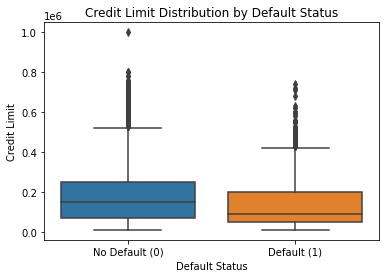

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    x='default.payment.next.month',
    y='LIMIT_BAL',
    data=df
)

plt.xticks([0, 1], ['No Default (0)', 'Default (1)'])
plt.xlabel('Default Status')
plt.ylabel('Credit Limit')
plt.title('Credit Limit Distribution by Default Status')

plt.show()



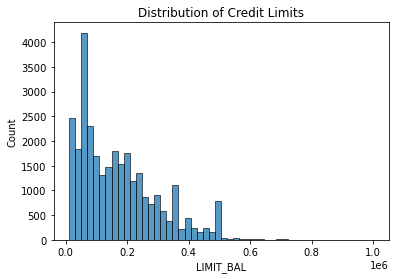

In [ ]:
sns.histplot(df['LIMIT_BAL'], bins=50)
plt.title('Distribution of Credit Limits')
plt.show()

"""
right-skewed credit limits
many low-limit cards, few high-limit ones
"""


In [ ]:
"""
The boxplot compares credit limits between borrowers who defaulted and those who did not, where 0 represents non-default and 1 represents default.
The entire distribution of credit limits for defaulters is shifted downward compared to non-defaulters.
The boxplot confirms that borrowers who default generally have lower credit limits than those who do not. While there is some overlap between the two groups, the median and interquartile range for defaulters are consistently lower, indicating that credit limit is a useful predictor of default risk.
"""

### 3. Repayment Status vs Default class

In [14]:
df.groupby('default.payment.next.month')['PAY_0'].describe()


,count,mean,std,min,25%,50%,75%,max
default.payment.next.month,,,,,,,,
0,23364.0,-0.211222,0.952464,-2.0,-1.0,0.0,0.0,8.0
1,6636.0,0.668174,1.383252,-2.0,0.0,1.0,2.0,8.0


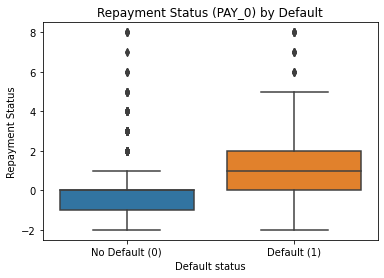

In [16]:
sns.boxplot(
    x='default.payment.next.month',
    y='PAY_0',
    data=df
)
plt.xticks([0, 1], ['No Default (0)', 'Default (1)'])
plt.title('Repayment Status (PAY_0) by Default')
plt.xlabel('Default status')
plt.ylabel('Repayment Status')
plt.show()


In [ ]:
"""
The boxplot shows a clear difference in repayment behavior between borrowers who default and those who do not. Non-defaulters are concentrated around on-time or early repayments, while defaulters exhibit higher repayment delays, reflected in a higher median and wider spread of PAY_0 values. This confirms that recent repayment status is a strong predictor of default risk.

"""

### 4. Bill amounts (debt burden) vs default status
#### Bill amounts capture outstanding debt. Even with the same credit limit, higher unpaid balances can increase default risk.

In [17]:
df.groupby('default.payment.next.month')['BILL_AMT1'].describe()


,count,mean,std,min,25%,50%,75%,max
default.payment.next.month,,,,,,,,
0,23364.0,51994.227273,73577.606694,-165580.0,3677.25,23119.5,69027.0,964511.0
1,6636.0,48509.162297,73782.067220,-6676.0,2987.75,20185.0,59626.5,613860.0


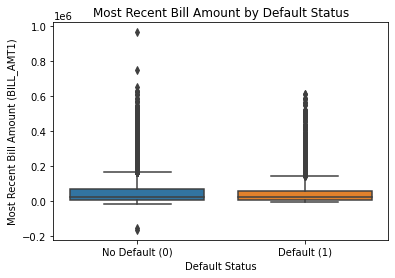

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    x='default.payment.next.month',
    y='BILL_AMT1',
    data=df
)

plt.xticks([0, 1], ['No Default (0)', 'Default (1)'])
plt.xlabel('Default Status')
plt.ylabel('Most Recent Bill Amount (BILL_AMT1)')
plt.title('Most Recent Bill Amount by Default Status')

plt.show()


In [ ]:
"""
The average and median bill amounts for defaulters and non-defaulters are relatively close.
Both groups show high variability and a large number of outliers, indicating wide differences in outstanding balances.
The boxplot shows substantial overlap between defaulters and non-defaulters, with no strong shift in the distribution similar to what we observed for repayment status.
Although non-defaulters have slightly higher upper-range values, the overall separation between the two groups is weak.

The summary statistics and boxplot indicate that bill amounts alone do not strongly distinguish defaulters from non-defaulters. While both groups exhibit wide variation and extreme outliers in outstanding balances, their median and interquartile ranges are largely overlapping. This suggests that bill amount, by itself, is a weaker predictor of default risk compared to recent repayment behavior, though it may still provide complementary information when combined with other features in the model.

"""

### 5. Age vs default status

In [19]:
df.groupby('default.payment.next.month')['AGE'].describe()


,count,mean,std,min,25%,50%,75%,max
default.payment.next.month,,,,,,,,
0,23364.0,35.417266,9.077355,21.0,28.0,34.0,41.0,79.0
1,6636.0,35.725738,9.693438,21.0,28.0,34.0,42.0,75.0


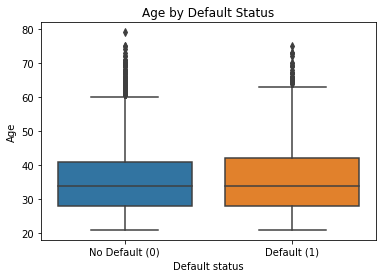

In [21]:
sns.boxplot(
    x='default.payment.next.month',
    y='AGE',
    data=df
)
plt.xticks([0, 1], ['No Default (0)', 'Default (1)'])
plt.title('Age by Default Status')
plt.xlabel('Default status')
plt.ylabel('Age')
plt.show()


In [ ]:
"""
The age distribution for defaulters and non-defaulters is broadly similar, with substantial overlap in both the median and interquartile range. Defaulters tend to be slightly younger on average, but the difference is modest. This suggests that age alone is not a strong predictor of default risk, though it may contribute marginally when combined with financial and repayment features.

"""

### 6. Gender vs default status

In [26]:
pd.crosstab(df['SEX'], df['default.payment.next.month'], normalize='index') * 100


default.payment.next.month,0,1
SEX,,
1,75.832773,24.167227
2,79.223719,20.776281


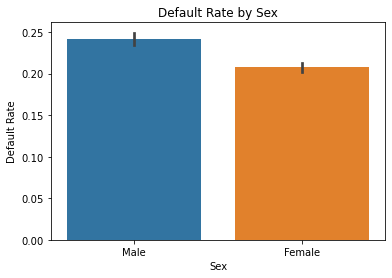

In [ ]:
sns.barplot(
    x='SEX',
    y='default.payment.next.month',
    data=df
)

plt.title('Default Rate by Sex')
plt.xlabel('Sex')
plt.ylabel('Default Rate')
plt.xticks([0, 1], ['Male', 'Female'])
plt.show()


In [ ]:
"""
The default rates for male and female borrowers are relatively similar, with only a small difference between the two groups. This indicates that sex is not a primary driver of default risk in this dataset, though it may still provide limited additional information when used alongside financial and repayment variables.
"""

### 7. Default status by education

In [29]:
pd.crosstab(
    df['EDUCATION'],
    df['default.payment.next.month'],
    normalize='index'
) * 100


default.payment.next.month,0,1
EDUCATION,,
0,100.000000,0.000000
1,80.765234,19.234766
2,76.265146,23.734854
3,74.842384,25.157616
4,94.308943,5.691057
5,93.571429,6.428571
6,84.313725,15.686275


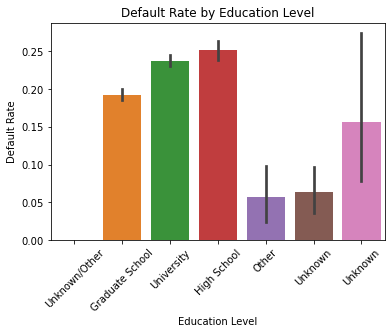

In [30]:
sns.barplot(
    x='EDUCATION',
    y='default.payment.next.month',
    data=df
)

plt.title('Default Rate by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Default Rate')
plt.xticks(
    ticks=[0, 1, 2, 3, 4, 5, 6],
    labels=[
        'Unknown/Other',
        'Graduate School',
        'University',
        'High School',
        'Other',
        'Unknown',
        'Unknown'
    ],
    rotation=45
)
plt.show()


In [ ]:
"""
Default rates vary modestly across education levels, with borrowers having lower formal education showing slightly higher default rates. However, the differences are not large, suggesting that education is a secondary predictor compared to repayment history and credit capacity.

"""

In [ ]:
### 8. Default status by marriage

In [31]:
pd.crosstab(
    df['MARRIAGE'],
    df['default.payment.next.month'],
    normalize='index'
) * 100


default.payment.next.month,0,1
MARRIAGE,,
0,90.740741,9.259259
1,76.528296,23.471704
2,79.071661,20.928339
3,73.993808,26.006192


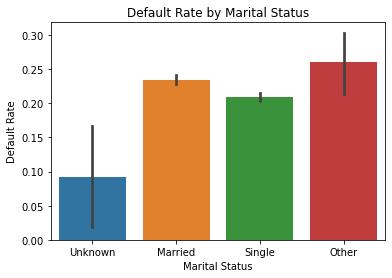

In [32]:
sns.barplot(
    x='MARRIAGE',
    y='default.payment.next.month',
    data=df
)

plt.title('Default Rate by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Default Rate')
plt.xticks(
    ticks=[0, 1, 2, 3],
    labels=['Unknown', 'Married', 'Single', 'Other']
)
plt.show()


In [ ]:
"""
Default rates differ slightly by marital status, with single borrowers exhibiting marginally higher default rates. Overall, marital status does not strongly separate defaulters from non-defaulters and is likely to play a supporting role in the predictive model.

"""

In [ ]:
## Wrapping up of EDA
""""
Exploratory data analysis on a few x variables against target variable reveals clear differences between borrowers who defaulted and those who did not. Default behavior is moderately imbalanced, with approximately 22% of borrowers defaulting in the following month. Credit capacity, measured by credit limit, shows a strong relationship with default, as defaulters tend to have lower credit limits. Recent repayment behavior is the strongest indicator of default risk, with defaulters exhibiting significantly worse repayment status compared to non-defaulters.
In contrast, bill amounts show substantial overlap between the two groups, suggesting that outstanding balances alone are a weaker predictor of default. Demographic variables such as age, sex, education, and marital status display only modest differences between defaulters and non-defaulters, indicating that they are likely to play a supporting rather than primary role in prediction. Overall, the analysis suggests that repayment history and credit capacity are the most informative features for modeling default risk.

""""
#for slides
""""
Exploratory analysis shows that repayment behavior and credit limits are the strongest indicators of default risk. Defaulters tend to have worse recent repayment status and lower credit limits, while demographic factors such as age, sex, education, and marital status show only modest differences. These insights motivate a predictive modeling approach that prioritizes behavioral and financial variables.
""""

## Model development

### 1. Logistic regression model

We first define the target variable and independent variables 
* The target variable represents whether a borrower defaults in the following month. 
* The independent set includes borrower demographics, credit capacity, repayment history, and billing information etc
* Identifier variables that do not contain predictive information are removed.


In [ ]:
# Define target variable and independent variables
# Define target variable
y = df['default.payment.next.month']
X = df.drop(columns=['ID', 'default.payment.next.month'])

In [ ]:
X.shape, y.shape

# This confirms that the predictors matrix (X) contains 23 independent variables and the target vector (y) contains the binary default outcome for all 30,000 observations.


((30000, 23), (30000,))

In [39]:
# Train test split
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 80% train, 20% test
    random_state=42,    # reproducibility
    stratify=y          # keeps same default rate in train and test
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((24000, 23), (6000, 23), (24000,), (6000,))

"""
## Feature Scaling

Since our dataset contains features with different scales (e.g., credit limits, bills, repayment statuses, etc.), it's important to standardize them.

If we train a logistic regression model without scaling, variables with large values may have a stronger influence on the model

To prevent this, we standardize them so that they are on a similar scale. This allows the model to learn from all variables more fairly and improves stability during training.

"""

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data ONLY
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to the test data
X_test_scaled = scaler.transform(X_test)

X_train_scaled

"""
The scaler is fitted only on the training data to prevent data leakage. 
The test data is transformed using the same parameters learned from the training set.

"""


array([[-0.05686623,  0.80844039,  0.18452304, ...,  0.08696116,
         0.50039738,  0.04874486],
       [-0.13408117,  0.80844039, -1.07753249, ..., -0.3180751 ,
        -0.31697847, -0.29299231],
       [-1.21509034, -1.23694958,  0.18452304, ..., -0.29855368,
        -0.29671021, -0.23696983],
       ...,
       [-0.36572599,  0.80844039, -1.07753249, ..., -0.18527633,
        -0.23723448, -0.23696983],
       [ 1.48743258, -1.23694958, -1.07753249, ..., -0.3180751 ,
        -0.31697847, -0.29299231],
       [ 1.02414294, -1.23694958, -1.07753249, ..., -0.3180751 ,
        -0.31697847, -0.29299231]])

In [43]:
# build the logistic model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize Logistic Regression
log_reg = LogisticRegression(random_state=42)

# Train the model on the scaled training data
log_reg.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = log_reg.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.8078333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000

Confusion Matrix:
 [[4529  144]
 [1009  318]]


In [ ]:
"""
Accuracy: 0.81 (81%)--model correctly predicted the outcome (default or not) for about 81% of the test samples.
Classification report:
The model correctly identifies 97% of non-defaulters (true negatives), showing strong performance in predicting safe borrowers.
However, it only captures 24% of actual defaulters (recall for default class), meaning the model misses about 76% of borrowers who actually default. This is explained by the fact that our dataset is imbalanced (only 22% of borrowers defaulting), the model naturally becomes biased toward predicting "non-defaulters", which therefore contributes to the low recall for the defaulters clas
From the confusion matrix, we see that there are 1,009 false negatives, meaning these are borrowers who defaulted but were predicted to be safe. This is a significant issue for risk management, as missing these high-risk borrowers could result in substantial financial losses.
Classification Report:
The classification report provides precision, recall, and F1-score for both classes (defaulters and non-defaulters).
For Non-Defaulters (Class 0):
Precision: 0.82
Interpretation: Out of all the instances that were predicted as "non-defaulters", 82% were correctly identified. A good performance.
Recall: 0.9
Interpretation: The model correctly identified 97% of the actual "non-defaulters". This is excellent, indicating that the model is great at catching non-defaulters.
F1-Score: 0.89
Interpretation: This is a balanced score between precision and recall for non-defaulters. A higher value means the model is not only accurate but also reliable in making predictions for this class.
For Defaulters (Class 1):
Precision: 0.69
Interpretation: Out of all the instances predicted as "defaulters", 69% were actually correct. While this is not terrible, it shows that the model tends to make a fair number of mistakes when predicting defaulters.
Recall: 0.24
Interpretation: The model only correctly identified 24% of the actual defaulters. This is a major concern, as the model is missing the majority of the defaulters. It indicates that the model is biased toward predicting "non-defaulters".
F1-Score: 0.36

Interpretation: This score reflects the trade-off between precision and recall for defaulters. The low score shows the model's poor performance for this class.
Detailed explanation of the confusion matrix:
True Negatives (TN): 4529 — The model correctly predicted 4529 non-defaulters.
False Positives (FP): 144 — 144 instances were incorrectly predicted as defaulters when they were actually non-defaulters.
False Negatives (FN): 1009 — 1009 actual defaulters were missed and predicted as non-defaulters.
True Positives (TP): 318 — The model correctly predicted 318 defaulters
Conclusion:
While this logistic regression serves as a useful baseline, its low recall for defaulters indicates that a more flexible model (such as Decision Tree or others) may be needed to better identify and mitigate the risk of default. We therefore proceed with decision tree maxtris which is often good with improving recall for minority class andin our case --defaulters
"""

### 2. Building the decision tree model

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize Decision Tree
dt = DecisionTreeClassifier(random_state=42)

# Train model
dt.fit(X_train, y_train)

# Predictions
y_pred_dt = dt.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


Accuracy: 0.7145

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81      4673
           1       0.37      0.41      0.39      1327

    accuracy                           0.71      6000
   macro avg       0.60      0.61      0.60      6000
weighted avg       0.73      0.71      0.72      6000


Confusion Matrix:
 [[3741  932]
 [ 781  546]]


In [ ]:
"""
## Decision Tree Results

The decision tree model achieved an accuracy of 71%, lower than logistic regression. However, recall for defaulters improved from 24% to 41%, meaning the model captures more high-risk borrowers.
Although logistic regression achieved very high recall for non-defaulters (97%), this reflects the class imbalance in the dataset rather than superior risk detection. The model captures only 24% of defaulters, missing the majority of high-risk borrowers.
The decision tree reduces recall for non-defaulters to 80% but improves recall for defaulters to 41%, significantly reducing missed defaulters. From a credit risk perspective, this trade-off is more aligned with the objective of identifying high-risk borrowers. 
False negatives decreased from 1,009 under logistic regression to 781 under the decision tree, reducing the number of missed defaulters. Although overall accuracy declined, the improved ability to detect default risk makes the decision tree more aligned with our goal of preditcing .

"""

### 3. Improving recall further and tuning the decision tree model

#### a)  Hyperparameter tuning

Current Decision Tree Model Results:

The decision tree model achieved an accuracy of 71%, which is lower than the baseline logistic regression model (81%). However, a closer inspection of recall values for defaulters reveals that the decision tree improved recall from 24% in logistic regression to 41%. This improvement means the decision tree captures more high-risk borrowers.

In logistic regression, the model correctly identified 97% of non-defaulters, but failed to detect a significant number of defaulters (only 24% recall for defaulters). This result is primarily due to the class imbalance, where the model tends to favor the non-default class, neglecting the high-risk default class.

The decision tree, while reducing recall for non-defaulters to 80%, shows a significant improvement in identifying defaulters. This trade-off is more aligned with our objective of identifying high-risk borrowers early, as it reduces the false negatives (from 1,009 in logistic regression to 781 in the decision tree). Although the overall accuracy has decreased, the model's ability to detect default risk makes it more suitable for the task.

Therefore:

We need to further tune the decision tree model to achieve a better balance between recall for defaulters and non-defaulters, without overfitting the model to the majority class. By tuning hyperparameters such as max depth, minimum samples per leaf, and others, we can further improve recall for defaulters while maintaining reasonable performance for non-defaulters.

In [46]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define the model
RANDOM_STATE = 42
dtree = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Set the hyperparameters for tuning
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters: ", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)



Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      4673
           1       0.37      0.41      0.39      1327

    accuracy                           0.71      6000
   macro avg       0.60      0.61      0.60      6000
weighted avg       0.73      0.71      0.72      6000

[[3741  932]
 [ 781  546]]


In [ ]:
"""
## Decision Tree Tuning Results

Hyperparameter tuning did not significantly improve recall for defaulters. 
The optimal tree was fully grown, indicating that model flexibility was not the primary limitation.

This suggests that class imbalance, rather than model complexity, is constraining performance.

To further improve recall for defaulters, we will adjust for class imbalance using class weighting.

"""

#### b) Feature Importance 

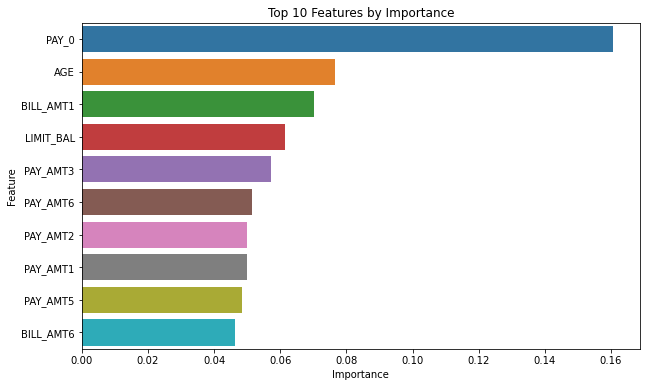

In [47]:
# Feature Importance from the best model
importances = best_model.feature_importances_

# Create DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 features
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title("Top 10 Features by Importance")
plt.show()


#### b) Handling Class Imbalance Using Class Weights

The dataset is moderately imbalanced, with approximately 22% defaulters and 78% non-defaulters. Because defaulters represent the minority class, the model may prioritize predicting non-default cases to maximize overall accuracy.

To address this issue, we applied `class_weight="balanced"` in the Decision Tree model. This adjusts the penalty for misclassifying each class, giving more importance to correctly identifying defaulters.

This approach encourages the model to focus more on detecting high-risk borrowers rather than simply optimizing overall accuracy.


In [48]:
# Importing the necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create the decision tree classifier with class_weight='balanced'
dtree_balanced = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')

# Fit the model
dtree_balanced.fit(X_train, y_train)

# Predict on the test data
y_pred_balanced = dtree_balanced.predict(X_test)

# Evaluate the model's performance
print("Classification Report (with class_weight='balanced'):")
print(classification_report(y_test, y_pred_balanced))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_balanced))


Classification Report (with class_weight='balanced'):
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      4673
           1       0.38      0.38      0.38      1327

    accuracy                           0.73      6000
   macro avg       0.60      0.60      0.60      6000
weighted avg       0.73      0.73      0.73      6000

Confusion Matrix:
[[3873  800]
 [ 827  500]]


In [ ]:
"""
## Decision Tree with Class Weights Results

After applying class weighting, recall for defaulters remained at 38%, compared to 41% in the previous decision tree model. Although recall did not improve, the model maintained a more balanced performance across both classes.
False negatives decreased from 1,009 in logistic regression to 827, meaning fewer defaulters were missed overall compared to the baseline model.
Accuracy improved slightly to 73%, but the key objective remains improving recall for defaulters. Further tuning focused specifically on recall may be required.

"""

#### 4. Hyperparameter tuning using grid search

In our previous decision tree model, recall for defaulters was at 41%. However, there were still room for improvement in both recall and overall model performance. To further enhance the model's ability to detect high-risk borrowers (defaulters), we applied hyperparameter tuning using `GridSearchCV`.

We tuned the `max_depth`, `min_samples_leaf`, and `min_samples_split` hyperparameters, which control the tree's complexity and its ability to generalize. The goal was to find a balance between underfitting and overfitting while improving recall for defaulters.


In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

RANDOM_STATE = 42  # set once and reuse

# Base model with class weights for imbalance
dtree = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced")

param_grid = {
    "max_depth": [3, 5, 8, 12, None],
    "min_samples_split": [2, 10, 20, 50],
    "min_samples_leaf": [1, 5, 10, 20]
}

grid = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    scoring="recall",   # prioritise catching defaulters
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_tree = grid.best_estimator_
y_pred_best = best_tree.predict(X_test)

print("Best Parameters:", grid.best_params_)
print(classification_report(y_test, y_pred_best))
print(confusion_matrix(y_test, y_pred_best))


Best Parameters: {'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 50}
              precision    recall  f1-score   support

           0       0.87      0.70      0.78      4673
           1       0.37      0.62      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.68      0.71      6000

[[3285 1388]
 [ 508  819]]


In [ ]:
"""
## Tuning Results and Interpretation

After applying hyperparameter tuning, the model achieved the following results:

- **Best Parameters**: `max_depth=None`, `min_samples_leaf=20`, `min_samples_split=50`
- **Precision**: 87% for non-defaulters (class 0), meaning the model is better at predicting non-default cases correctly.
- **Recall**: 62% for defaulters (class 1), a significant improvement from the earlier 41%. This means the model is now identifying more of the high-risk borrowers.
- **F1-Score**: 46% for defaulters, indicating improved performance in balancing recall and precision.

While the accuracy dropped slightly to 68% (compared to 71% earlier), this is expected given the class imbalance. The real improvement is in recall for defaulters, aligning better with the primary goal of identifying high-risk borrowers.

The confusion matrix shows:
- 819 true positives (correctly predicted defaulters)
- 508 false negatives (missed defaulters, lower than before)
- 1388 false positives (misclassified non-defaulters as defaulters)

This suggests a trade-off where recall improves at the cost of precision, but the model is now much better at detecting defaulters.

"""

In [ ]:
"""
## Final Model Selection

The tuned decision tree model is selected as the final model.

Although its overall accuracy (68%) is lower than logistic regression (81%), it achieves substantially higher recall for defaulters (62% vs 24%). This means the model is significantly better at identifying high-risk borrowers.

From a credit risk perspective, reducing missed defaulters is more important than maximizing overall accuracy. The tuned decision tree reduces false negatives from 1,009 (logistic regression) to 508, cutting missed defaulters by nearly half.

Therefore, the tuned decision tree better aligns with the objective of predicting default risk and minimizing financial losses.

"""

#### Feature Importance for Final Tuned Model

In [50]:
best_tree = grid.best_estimator_
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importances from tuned model
importances = best_tree.feature_importances_

# Create DataFrame
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Show top features
feature_importance_df.head(10)



,Feature,Importance
5,PAY_0,0.409084
18,PAY_AMT2,0.064327
11,BILL_AMT1,0.053609
0,LIMIT_BAL,0.051794
19,PAY_AMT3,0.038097
20,PAY_AMT4,0.036734
12,BILL_AMT2,0.036294
4,AGE,0.033846
13,BILL_AMT3,0.029801
22,PAY_AMT6,0.029595


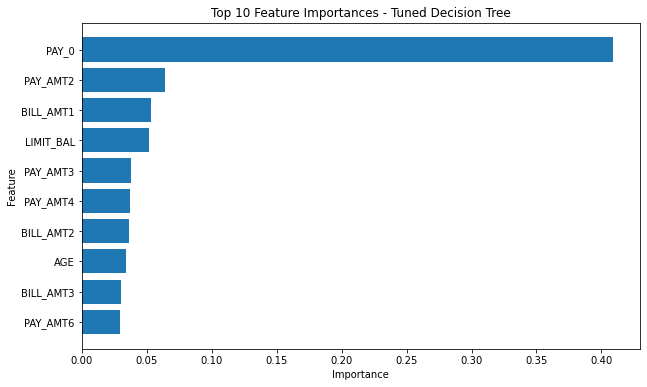

In [51]:
plt.figure(figsize=(10,6))
plt.barh(
    feature_importance_df["Feature"][:10],
    feature_importance_df["Importance"][:10]
)
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances - Tuned Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [ ]:
"""
## Feature Importance Interpretation

The tuned decision tree identifies PAY_0 (most recent repayment status) as the strongest predictor of default.

PAY_0 represents how late a borrower was in their most recent payment month. Higher values indicate longer payment delays. The model’s reliance on this feature indicates that recent delinquency behavior is the most powerful signal of future default risk.

This finding aligns with financial intuition. Borrowers who are already late on payments are significantly more likely to default in the following month.

From a business perspective, this suggests that early warning systems should prioritize recent payment delays when assessing credit risk.
"""

### Model Evaluation

After tuning the decision tree using GridSearchCV, we selected the model with the best hyperparameters based on recall for defaulters.

In this section, we evaluate the performance of the final tuned model on the test dataset and interpret its results in the context of credit risk prediction.

#### Evaluation Metrics

We evaluate the model using the following metrics:

- Precision
- Recall
- F1-score
- Confusion Matrix
- ROC-AUC

Recall for defaulters remains the primary metric because failing to identify high-risk borrowers can lead to financial losses.

Our aim is to ensure the model performs well in identifying defaulters while minimizing false positives (i.e., predicting someone will default when they do not).



In [52]:
# Best tuned decision tree model evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions with the best model
y_pred_best = best_tree.predict(X_test)

# Print the classification report and confusion matrix
print("Best Parameters:", grid.best_params_)
print(classification_report(y_test, y_pred_best))
print(confusion_matrix(y_test, y_pred_best))


Best Parameters: {'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 50}
              precision    recall  f1-score   support

           0       0.87      0.70      0.78      4673
           1       0.37      0.62      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.68      0.71      6000

[[3285 1388]
 [ 508  819]]


In [ ]:
"""
## Feature Importance Analysis

To better understand how the model makes decisions, we examine feature importance from the tuned decision tree.

This helps identify which borrower characteristics most strongly influence default risk predictions.

"""

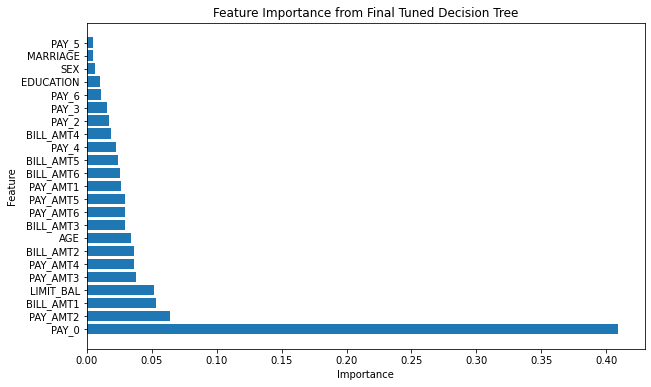

In [53]:
# Feature importance from the final tuned decision tree
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = best_tree.feature_importances_

# Create a DataFrame with feature names and importance values
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Final Tuned Decision Tree')
plt.show()
